# Optimizing array layout for all-sky radio telescopes using the condition number of the telescope operator

by Tim Molteno (tim@elec.ac.nz)

The discrete sky telescope operator [1] is a linear measurement operator that maps sky-vectors to visibility measurements. This works for arbitrary fields of view, non-coplanar baselines and non-flat skies.

Here we use the condition number of the Moore-Penrose inverse of the telescope operator as an optimization criterion for choosing antenna array layouts.


## Theory

The Moore-Penrose inverse,  $A^+$, (or pseudoinverse) of the telescope operator $A$, maps visibilities to sky-vectors. It can be interpreted as providing the solution, $s$, to the inverse problem $v = A s$, with minimum euclidian norm. Using the SVD of A we can write

$ A = U \Sigma V^H $
or
$ A^H = V \Sigma^H U^H $

and so
$ y = A x = U \Sigma V^H x $
which means:
$ V \Sigma^H U^H y = V \Sigma^H U^H U \Sigma V^H x $, and so

$ V \Sigma^H U^H y = V \Sigma^H \Sigma V^H x $

$A^+ = V \Sigma^+ U^\star$
The condition number of $A^+$ is the ratio between the largest and smallest (non-zero) singular value.

Using the pseudoinverse and a matrix norm, one can define a condition number for any matrix:

\[ cond ( A ) = ‖ A ‖ ‖ A + ‖  \]

A large condition number implies that the problem of finding least-squares solutions to the corresponding system of linear equations is ill-conditioned in the sense that small errors in the entries of A {\displaystyle A} A can lead to huge errors in the entries of the solution.[27] 


The condition number is the radio of the largest to the smallest singular values of the matrix.

 $cond(A) = \frac{\sigma_0}{\sigma_n} $

### Condition number and uncertainty

The point here is to optimize the telescope operator to minimize the posterior variance when a sky is inferred from some observations. In the discrete operator case, we can make statements about how a gaussian prior sky is inferred by Bayes' rule into a posterior sky [cite the paper]

The ideal telescope operator inversion would maximally reduce the entropy of the posterior sky. In other words, the variance of the posterior would be minimized.

In the natural basis, the telescope operator is invertible, and in this basis, the posterior variance can be computed from $A^{-1}$. 

The entropy of the posterior is
$\ln(\det ( 2 \pi e \Sigma ))$

Where the SVD gives us the determinant as the product of the singular values of a matrix.

## Gradient Descent optimization

Recent work on calculating the gradient of the SVD of a matrix [cite tensorflow stuff]
means that gradient descent algorithms can be applied to optimize the condition number
as a function of the antenna positions. Automatic differentiation can be applied to compute the gradients 

 $ \frac{d K(A)}{d x_i} $
 
 of the condition number, $K(A)$ with respect to the antenna positions $x_i$. The optimization of $K(A)$ can be done using stochastic gradient descent, and carried out using standard machine-learning frameworks.
 
 
 ## All-sky Y-array example
 
 COnsider a three-branch 'Y' antenna array consisting of branches equally spaced around the circle, each with $N$ antennas per branch. The $3N$ distances $x_i$ of of the $i$th antenna from the center of the array for m the optimization variables in this problem.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## Testing the constraining of inputs

The inputs to the optimization function must not allow negative positions along the arms (otherwise the array effectively has six arms). To ensure this we pass the list of radius values through a function that maps all values to positive numbers.

This function must be differentiable so that the gradient of the condition number can be determined.

In [2]:
x = np.linspace(-2,10,100)

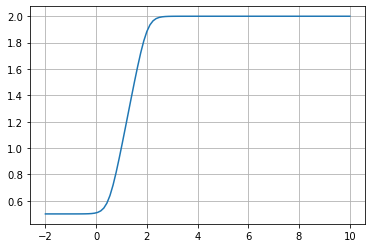

In [3]:
def constrain(x, lower, upper, sharpness=6):
    clip_lower = tf.math.softplus((x-lower)*sharpness)/sharpness + lower
    return upper - tf.math.softplus((-clip_lower + upper)*sharpness)/sharpness

y = constrain(x,0.5,2)
plt.plot(x,y.numpy())
plt.grid(True)

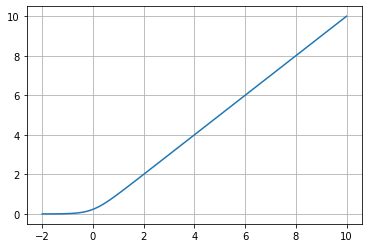

In [4]:
sharpness = 3
y = tf.math.softplus(x*sharpness)/sharpness
plt.plot(x,y.numpy())
plt.grid(True)

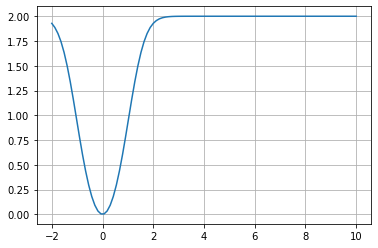

In [5]:
y = (tf.math.sigmoid(x**2)-0.5)*4
plt.plot(x,y.numpy())
plt.grid(True)

Both of these functions do pretty well at mapping all values to between 0..2.  I'll use the softmax version.

## Penalizing antennas that are close together

We need a differentiable function that is nonzero when an antenna pair is closer than some threshold.

In [6]:
def penalize(duv2, limit=0.2):
    sharpness = 50
    duv = tf.sqrt(duv2)
    clip_lower = tf.math.softplus((limit - duv)*sharpness)/sharpness
    return (clip_lower/limit)**2

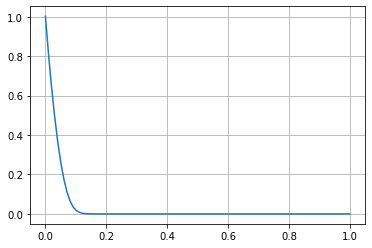

In [7]:
du = np.linspace(0,1,100)
plt.plot(du, penalize(du**2, limit=0.1))
plt.grid(True)

## Optimization Strategy

Tensorflow has recently included the derivative of the SVD operator, so we can compute the gradient of the antenna positions with respect to the condition number!. This is shit hot, and opens up standard optimization strategies to  find optimum array layouts.

### Cost Function

Penalize antennas too close together? 

### Starting Layout

Currently random, but may make sense to start with a perturbed uniform.

## Results

The advantage of using condition number as an optimization criterion is that it provides a quantitative measure of the quality of the inversion that is possible when imaging from the array.

### Choice of Optimizer

We use tensorflow which allows the use of stochastic gradient minimizers that can auto-differentiate the SVD operation. The source code for this strategy is in github [https://github.com/tmolteno/TART-3/tree/master/array/disko_array_opt].

In [8]:
import json
with open('best.json', 'r') as f:
    results = json.load(f)

results['condition_number']

4.363842077438133

In [9]:
import array_opt
ant = array_opt.YAntennaArray.from_json('best.json')

INFO: nside=1 res=3517.9380857010237 arcmin
INFO: nside=2 res=1758.9690428505119 arcmin
INFO: nside=4 res=879.4845214252559 arcmin
INFO: nside=8 res=439.74226071262797 arcmin
INFO: nside=16 res=219.87113035631398 arcmin
INFO: nside=32 res=109.93556517815699 arcmin
INFO: New SubSphere, nside=32
INFO: New SubSphere, nside=32. npix=5056


Text(0.5, 1.0, 'Optimized antenna layout')

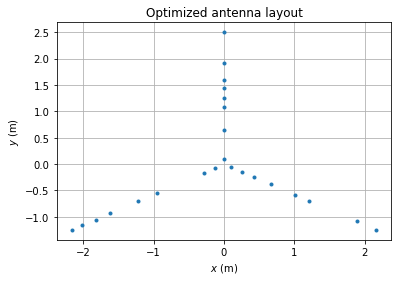

In [10]:
ant_pos = ant.get_ant_pos(ant.arms)
plt.plot(ant_pos[:,0], ant_pos[:,1], '.')
plt.grid(True)
plt.xlabel("$x$ (m)")
plt.ylabel("$y$ (m)")
plt.title('Optimized antenna layout')

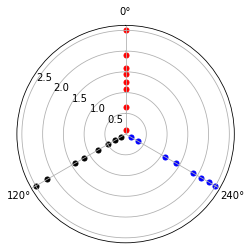

In [11]:
theta = np.zeros_like(ant.arms[0])
angles = (0, 120, 240)
r = ant.arms[0]
area = 25
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.set_thetagrids(angles)
ax.set_rlabel_position(60)
ax.set_theta_zero_location("N")
c0 = ax.scatter(theta, ant.arms[0], c='red', s=area, alpha=1)
c120 = ax.scatter(theta + np.radians(120), ant.arms[1], c='black', s=area, alpha=1)
c240 = ax.scatter(theta + np.radians(240), ant.arms[2], c='blue', s=area, alpha=1)

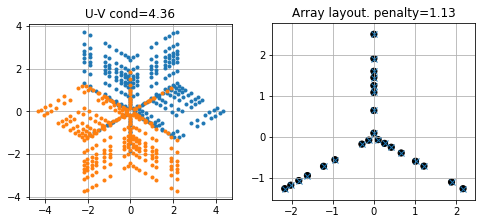

In [12]:
ant.init_plot()
x_opt = array_opt.constrain(ant.x, ant.radius_min, ant.radius)
ant.plot_uv('best.pdf', x_opt,
            results['penalty'],
            results['condition_number'])

## Robustness of solutions

There is a reasonable question about how robust the solutions are to small changes in parameters. This will be tested by considering different potential factors

* Pixelization
* Errors in antenna position

### Pixelization 

Pixelization does not appear to change the optimization function much. Starting at a solution with 5000 pixels, and reducing the resolution so that npix=1248 results in a very similar optimium.

    python3 array_opt.py --iter=10000 --fov=160 --arcmin=360 \
        --radius=2.5 --learning-rate=0.001 \
        --initial best.json
        
Increasing the resolution to 90 arc minutes (or 22000 pixels) produces a similar result.

### Errors in Antenna position

This is tested using random offsets from the optimium array antenna positions. We expect from reference[1] that the effect on inversions of the telescope operator by perturbations of the telescope operator matrix (caused by modifications of the antenna positions) will be bounded above by the condition number, and therefore these solutions will be robust.

A numerical experiment involving adding random offsets to the antenna locations shows that this is the case. Figure, shows a histogram of condition number for solutions of a 24-element Y antenna with an arm-length of 2.5 meters. The antennas are perturbed with a zero-mean gaussian with a standard deviation of 1mm.

In [13]:
n_trials = 1000
try:
    res = np.load('res.npy')
except:
    radius_min = 0.1
    array_opt.init(radius_min, ant)
    res = []
    delta = 1e-3   # 1 mm
    for i in range(n_trials):
        _x, _y, _z = array_opt.get_ant_pos(ant.x)
        _x += np.random.normal(0, delta, _x.shape[0])
        _y += np.random.normal(0, delta, _y.shape[0])
        _z += np.random.normal(0, delta, _z.shape[0])
        penalty, cond = array_opt.global_f(_x, _y, _z)
        res.append(cond.numpy())
    res = np.array(res)
    np.save('res.npy', res)

C/N=4.415216851665352  penalty=1.1418733147332916
C/N=4.376708812307434  penalty=1.1288389077931675
C/N=4.367138536704168  penalty=1.130591321106689
C/N=4.423041522192989  penalty=1.1257679274817822
C/N=4.420756432864794  penalty=1.1253882992723863
C/N=4.429742316805437  penalty=1.1200151775734895
C/N=4.3325791746331275  penalty=1.1362646344644458
C/N=4.398601444094846  penalty=1.1245770720351098
C/N=4.397693435071339  penalty=1.1378414636353966
C/N=4.400378963449325  penalty=1.126660203887043
C/N=4.337543520267308  penalty=1.1367847811520004
C/N=4.378828080426783  penalty=1.1244715147966728
C/N=4.358418995863393  penalty=1.1505780824035463
C/N=4.443873134775936  penalty=1.124928538719991
C/N=4.395909502025914  penalty=1.1387757009119865
C/N=4.696583734558435  penalty=1.127568431117908
C/N=4.56189131710924  penalty=1.1184952612715269
C/N=4.459387748819884  penalty=1.1240084185230355
C/N=4.364531210787221  penalty=1.13120602238376
C/N=4.43189245587244  penalty=1.1218899073733914
C/N=4.3

C/N=4.393641817810506  penalty=1.1295990136743352
C/N=4.391304078950466  penalty=1.1304029369272082
C/N=4.350761361607465  penalty=1.1281504884801639
C/N=4.478737048242565  penalty=1.1243194844737379
C/N=4.4019972744925076  penalty=1.1360285736235793
C/N=4.3359472199568225  penalty=1.1399388629466218
C/N=4.445232275634207  penalty=1.1174457554091874
C/N=4.378211849572931  penalty=1.1446337540257758
C/N=4.396956840530899  penalty=1.123659426786008
C/N=4.496317017727898  penalty=1.127213521027543
C/N=4.370285160500672  penalty=1.1374774803123753
C/N=4.3706161519103235  penalty=1.1352543470938072
C/N=4.352409714422243  penalty=1.1387543397259317
C/N=4.376531805137362  penalty=1.132421787703697
C/N=4.44132528124718  penalty=1.1282717682498655
C/N=4.367089238024086  penalty=1.1394535645871264
C/N=4.34879071697829  penalty=1.1411898348014058
C/N=4.341480177528621  penalty=1.1352254084337114
C/N=4.4290337123484775  penalty=1.1184577357304917
C/N=4.408369050496156  penalty=1.126787613698419
C/

C/N=4.429467270556029  penalty=1.1254145536546887
C/N=4.340767851225779  penalty=1.1339579880154396
C/N=4.413982493380134  penalty=1.1281709109773237
C/N=4.422401450064504  penalty=1.1256546988892306
C/N=4.473273639573912  penalty=1.1337101591380603
C/N=4.381827709014155  penalty=1.1305156273532295
C/N=4.36697234589384  penalty=1.139252716582025
C/N=4.471924337140517  penalty=1.123907461805412
C/N=4.397543599519052  penalty=1.13403304594829
C/N=4.412585073881705  penalty=1.1243289379023416
C/N=4.509636351057912  penalty=1.116749523339203
C/N=4.389388460909296  penalty=1.135583356023125
C/N=4.4412490134938585  penalty=1.1159335165585647
C/N=4.4096062159275915  penalty=1.1400544271374047
C/N=4.3795075454273675  penalty=1.1396733202168856
C/N=4.406779570421268  penalty=1.126442734842469
C/N=4.3442037526606985  penalty=1.1377906071880155
C/N=4.397628213493012  penalty=1.1228357247455543
C/N=4.419277756272651  penalty=1.1357799551153243
C/N=4.439889947658388  penalty=1.13489444077607
C/N=4.

C/N=4.479289464062807  penalty=1.118143855550565
C/N=4.39612209228584  penalty=1.120599522663496
C/N=4.453242447482667  penalty=1.1240426752865489
C/N=4.37214897234786  penalty=1.1291161605087472
C/N=4.374403271684885  penalty=1.1460127179504147
C/N=4.388393748935271  penalty=1.1283954079812306
C/N=4.396154651132084  penalty=1.1358291975532826
C/N=4.35299652882497  penalty=1.1368395954450061
C/N=4.395053275724837  penalty=1.133985362311062
C/N=4.404583657166113  penalty=1.1245076486423955
C/N=4.470823091417572  penalty=1.1228956134263555
C/N=4.401669548950353  penalty=1.123224658742499
C/N=4.419041506200208  penalty=1.1300419061322466
C/N=4.520978896979948  penalty=1.116588665017669
C/N=4.397039777524646  penalty=1.127318462282464
C/N=4.459049372528984  penalty=1.1461713238077647
C/N=4.353214008283141  penalty=1.1381061575962517
C/N=4.384861158650666  penalty=1.1297123597821341
C/N=4.4856244366060825  penalty=1.1199556479718338
C/N=4.473945433885286  penalty=1.114681434836365
C/N=4.469

C/N=4.359285867291624  penalty=1.1410036511502388
C/N=4.507733704623038  penalty=1.1298166279822293
C/N=4.529463187647843  penalty=1.1112104220314996
C/N=4.349633995792193  penalty=1.145793765912142
C/N=4.466540967954693  penalty=1.1221892936584499
C/N=4.430473879496775  penalty=1.118015551011932
C/N=4.419532123748567  penalty=1.1377081275251195
C/N=4.374525332775986  penalty=1.1340244570716378
C/N=4.373730342523752  penalty=1.1359524599161877
C/N=4.390093286919073  penalty=1.1274038051401545
C/N=4.372919346534488  penalty=1.1310194817265797
C/N=4.374771221922249  penalty=1.1358971059615026
C/N=4.347392286787646  penalty=1.1376035441448775
C/N=4.401846183595959  penalty=1.1271682123420654
C/N=4.377586218843234  penalty=1.141295817673713
C/N=4.394784000624862  penalty=1.1261570416534594
C/N=4.447507542854948  penalty=1.1298331141693745
C/N=4.41569356407453  penalty=1.1241363099358321
C/N=4.4141304730318325  penalty=1.1230472417304092
C/N=4.503606099552483  penalty=1.1272600262494308
C/N

C/N=4.417441878187508  penalty=1.1285279031416835
C/N=4.451019391020282  penalty=1.123090919321332
C/N=4.367579995625837  penalty=1.139909652674057
C/N=4.425999871475102  penalty=1.1321085230218277
C/N=4.386431073050176  penalty=1.1337183568431883
C/N=4.403353566002194  penalty=1.128086284295774
C/N=4.415064469052907  penalty=1.1324697969561468
C/N=4.410525249934909  penalty=1.1258360383640935
C/N=4.508854713631901  penalty=1.129810270468572
C/N=4.702684508601843  penalty=1.1124511809189916
C/N=4.349848262560617  penalty=1.133059028146774
C/N=4.385161039163256  penalty=1.1391861373455319
C/N=4.394552229284579  penalty=1.138736410019115
C/N=4.392803984298774  penalty=1.1393738765601449
C/N=4.3649071338061285  penalty=1.1433550698742672
C/N=4.330142973180286  penalty=1.1440135292667752
C/N=4.452207782088957  penalty=1.127947233337097
C/N=4.426029527345396  penalty=1.1359838231418753
C/N=4.409873494623456  penalty=1.1238226025560334
C/N=4.494552203587629  penalty=1.1247208897153025
C/N=4.

C/N=4.382570081926767  penalty=1.1306775503206796
C/N=4.526090580280091  penalty=1.1106743791225306
C/N=4.399704418762225  penalty=1.124585388512265
C/N=4.354036781408449  penalty=1.1316760553083856
C/N=4.372312488639093  penalty=1.1305393311307599
C/N=4.479452370193645  penalty=1.134368420418572
C/N=4.311481396678407  penalty=1.1391520334965626
C/N=4.3701612831284935  penalty=1.1296762064900867
C/N=4.332033317612995  penalty=1.1376891075966384
C/N=4.336546979455601  penalty=1.1484090338556687


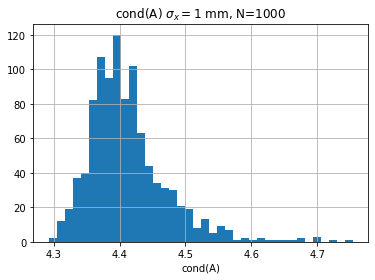

In [14]:
plt.hist(res, bins='fd')
plt.title('cond(A) $\sigma_x=1$ mm, N={}'.format(n_trials))
plt.xlabel('cond(A)')
plt.grid(True)
plt.savefig('cond_histogram.pdf')

In [15]:
n_trials = 1000
try:
    res5 = np.load('res5.npy')
except:
    radius_min = 0.1
    array_opt.init(radius_min, ant)
    res5 = []
    delta = 5e-3   # 1 mm
    for i in range(n_trials):
        _x, _y, _z = array_opt.get_ant_pos(ant.x)
        _x += np.random.normal(0, delta, _x.shape[0])
        _y += np.random.normal(0, delta, _y.shape[0])
        _z += np.random.normal(0, delta, _z.shape[0])
        penalty, cond = array_opt.global_f(_x, _y, _z)
        res5.append(cond.numpy())
    res5 = np.array(res5)
    np.save('res5.npy', res5)

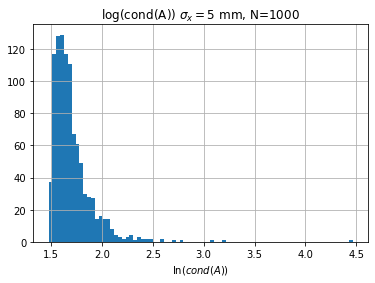

In [16]:
plt.hist(np.log(res5), bins='fd')
plt.title('log(cond(A)) $\sigma_x=5$ mm, N={}'.format(n_trials))
plt.xlabel('$\ln(cond(A))$')
plt.grid(True)
plt.savefig('cond_histogram5.pdf')

We can conclude that, in this array, if antenna position errors can be kep below 1mm, the condition number of the resulting telescope operator is likely to remain close to the optimal value.

## Comparison with Traditional techniques

Traditionally optimization is based on the PSF of the telescope [Thomson Moran and Swenson] calculated from an inverse FFT of the U-V plane. 

There are two bases for comparison. One is to compute the condition number for a traditional telescope (such as meerkat, or VLA) the other is to evaluate to the solutions found here using these traditional criteria.

### Comparison with the existing TART-2 array

The TART-2 array was designed to minimize the sidelobes in the PSF of the array. This optimization was carried out using four identical tiles that are placed in different orientations to achieve optimal behaviour. 

    TODO. Read JSON file of antenna positions, and construct the u,v,w 

### Evaluation of cond-optimized arrays

While wide field arrays with very large fields of view are 

## References

* http://www.math.bas.bg/infres/MathBalk/MB-15/MB-15-035-048.pdf An excellent overview which includes the use of K(A) to deal with Moore-Penrose inverses.
* In https://stanford.edu/~boyd/papers/pdf/diag_scaling_DR_ADMM.pdf we find the interesting statement. Minimization of the pseudo condition numberλmax/λmin>0can be posed as a convex optimization problem and be solved exactly, see [15, Section 6] which also contains heuristics to reduce the pseudo condition number. Reference 15 is ". Giselsson and S. Boyd.  Metric selection in fast dual forwardbackward splitting.Automatica, 2014." see below
* https://web.stanford.edu/~boyd/papers/pdf/metric_select_fdfbs.pdf 
* Cook, R. Dennis; Forzani, Liliana. On the mean and variance of the generalized inverse of a singular Wishart matrix. Electron. J. Statist. 5 (2011), 146--158. doi:10.1214/11-EJS602. https://projecteuclid.org/euclid.ejs/1300198786
* https://www.jstor.org/stable/2983755?seq=1 This is by Rao, and looks really really good. SImilarly, by Mitra https://doi.org/10.1016/S0169-7161(80)80045-9